In [59]:
import os
from functions import *
import networkx as nx

In [60]:
path = 'GoT_files'

pages = os.listdir(path)
page_titles = [f for f in pages if not f.startswith('fetched_pages_')]
page_titles = [f for f in page_titles if not f.startswith('redirects_')]
page_titles = [f for f in page_titles if not f.startswith('failed_pages_')]

In [61]:
page_texts = load_all_files()

In [62]:
def get_links_by_section(file: str, path: str = 'GoT_files', no_files: bool = True, no_translations: bool = True) -> dict:
    """Extract links from a wiki page, organized by section.
    
    Args:
        file: Filename to read (e.g., 'Page Name.txt')
        path: Directory containing the file
        no_files: If True, exclude File: and Image: links
        no_translations: If True, exclude translation links (e.g., [[de:...]])
    
    Returns:
        Dictionary with structure:
        {
            'sections': {
                'Section Name': {
                    'subsections': {
                        'Subsection Name': ['link1', 'link2', ...],
                        ...
                    },
                    'links': ['link1', 'link2', ...]  # Links directly under this section
                },
                ...
            },
            'header': ['link1', 'link2', ...],  # Links before first section
            'categories': ['category1', 'category2', ...]  # Links after <!--Categories-->
        }
    """
    
    with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
        text = f.read()
    
    # Build regex pattern for links
    if no_files and no_translations:
        link_pattern = r"\[\[(?!\w{2,5}(?:-\w{2})?:)(?!File:)(?!Image:)(.+?)\]\]"
    elif no_files:
        link_pattern = r"\[\[(?!File:)(?!Image:)(.+?)\]\]"
    elif no_translations:
        link_pattern = r"\[\[(?!\w{2,5}(?:-\w{2})?:)(.+?)\]\]"
    else:
        link_pattern = r"\[\[(.+?)\]\]"
    
    result = {
        'sections': {},
        'header': [],
        'categories': []
    }
    
    # Split text into parts
    lines = text.split('\n')
    
    current_section = None
    current_subsection = None
    in_categories = False
    
    for i, line in enumerate(lines):
        # Check if we've reached categories
        if '<!--Categories-->' in line:
            in_categories = True
            continue
        
        # Check for section headers
        section_match = re.match(r'^==(.*?)==\s*$', line)
        subsection_match = re.match(r'^===(.*?)===\s*$', line)
        
        if section_match and not subsection_match:
            # Main section (== Section ==)
            current_section = section_match.group(1).strip()
            current_subsection = None
            if current_section not in result['sections']:
                result['sections'][current_section] = {
                    'subsections': {},
                    'links': []
                }
        elif subsection_match:
            # Subsection (=== Subsection ===)
            current_subsection = subsection_match.group(1).strip()
            if current_section:
                if current_subsection not in result['sections'][current_section]['subsections']:
                    result['sections'][current_section]['subsections'][current_subsection] = []
        
        # Extract links from this line
        matches = re.findall(link_pattern, line)
        
        for match in matches:
            # Clean the link (remove pipe syntax)
            if '|' in match:
                link = match.split('|')[0]
            else:
                link = match
            
            # Skip category links in normal sections
            if link.startswith('Category:') or link.startswith('category:'):
                if in_categories:
                    result['categories'].append(link.replace('Category:', '').replace('category:', ''))
                continue
            
            # Add to appropriate location
            if in_categories:
                continue  # Skip non-category links after <!--Categories-->
            elif current_subsection and current_section:
                result['sections'][current_section]['subsections'][current_subsection].append(link)
            elif current_section:
                result['sections'][current_section]['links'].append(link)
            else:
                result['header'].append(link)
    
    return result

In [63]:
# Test the new function on one page
test_sections = get_links_by_section('A Golden Crown.txt')

# Print structure
print("Header links:", len(test_sections['header']))
print("\nSections:", list(test_sections['sections'].keys()))
print("\nCategories:", test_sections['categories'][:5], "...")

# Example: What's in the Synopsis section?
if 'Synopsis' in test_sections['sections']:
    synopsis = test_sections['sections']['Synopsis']
    print("\nSynopsis subsections:", list(synopsis['subsections'].keys()))
    print("Synopsis direct links:", synopsis['links'][:5] if len(synopsis['links']) > 0 else "none")

Header links: 14

Sections: ['Premise', 'Synopsis', 'Appearances', 'Cast', 'Quotes', 'Behind the scenes', 'In the books', 'Gallery', 'References', 'External links']

Categories: ['Episodes directed by Daniel Minahan', 'Episodes of Game of Thrones: Season 1', 'Episodes released in 2011', 'Episodes written by D.B. Weiss', 'Episodes written by David Benioff'] ...

Synopsis subsections: ['In the Crownlands', 'In the North', 'At the Eyrie', 'In Vaes Dothrak']
Synopsis direct links: none


In [64]:
# Build graph with section information
DG_sections = nx.DiGraph()

# First pass: add all nodes
for page in page_texts.keys():
    DG_sections.add_node(page)

print(f"Added {DG_sections.number_of_nodes()} nodes")

Added 5709 nodes


In [65]:
# Second pass: add edges with section information and node attributes
category_map = load_category_mapping()

for page in page_texts.keys():
    file = page + '.txt'
    section_data = get_links_by_section(file)
    
    # Store categories as node attribute
    cleaned_categories = clean_categories(section_data['categories'], category_map)
    DG_sections.nodes[page]['categories'] = cleaned_categories
    
    # Process header links
    for link in section_data['header']:
        if link in DG_sections.nodes():
            # Check if edge already exists
            if DG_sections.has_edge(page, link):
                # Add to existing sections list
                DG_sections[page][link]['sections'].append('header')
            else:
                # Create new edge with sections list
                DG_sections.add_edge(page, link, sections=['header'])
    
    # Process section links
    for section_name, section_content in section_data['sections'].items():
        # Links directly under section
        for link in section_content['links']:
            if link in DG_sections.nodes():
                section_label = section_name
                if DG_sections.has_edge(page, link):
                    DG_sections[page][link]['sections'].append(section_label)
                else:
                    DG_sections.add_edge(page, link, sections=[section_label])
        
        # Links in subsections
        for subsection_name, links in section_content['subsections'].items():
            for link in links:
                if link in DG_sections.nodes():
                    section_label = f"{section_name} > {subsection_name}"
                    if DG_sections.has_edge(page, link):
                        DG_sections[page][link]['sections'].append(section_label)
                    else:
                        DG_sections.add_edge(page, link, sections=[section_label])
    
    # Process categories as edges
    for cat in cleaned_categories:
        if cat in DG_sections.nodes():
            if DG_sections.has_edge(page, cat):
                DG_sections[page][cat]['sections'].append('categories')
            else:
                DG_sections.add_edge(page, cat, sections=['categories'])

print(f"Graph has {DG_sections.number_of_nodes()} nodes and {DG_sections.number_of_edges()} edges")

Graph has 5709 nodes and 200921 edges


In [66]:
# Example: Examine edges from a specific page
page_name = 'A Golden Crown'
if page_name in DG_sections.nodes():
    edges = DG_sections.out_edges(page_name, data=True)
    print(f"Edges from '{page_name}':\n")
    
    # Show first 10 edges with their section information
    for i, (source, target, data) in enumerate(list(edges)[:10]):
        sections = data.get('sections', [])
        print(f"{i+1}. {target}")
        print(f"   Sections: {', '.join(sections)}")
    
    print(f"\n... and {len(list(edges)) - 10} more edges")

Edges from 'A Golden Crown':

1. Jane Espenson
   Sections: header, header
2. David Benioff
   Sections: header, header
3. D.B. Weiss
   Sections: header, header
4. Daniel Minahan
   Sections: header, header
5. The Wolf and the Lion
   Sections: header
6. You Win or You Die
   Sections: header
7. Game of Thrones
   Sections: header
8. HBO
   Sections: header
9. Jaime Lannister
   Sections: Synopsis > In the Crownlands, Cast > Notes
10. Robert Baratheon
   Sections: Synopsis > In the Crownlands, Cast > Starring, Quotes

... and 161 more edges


In [67]:
# Example: Create subgraph of only "Synopsis" section links
synopsis_edges = []
for source, target, data in DG_sections.edges(data=True):
    sections = data.get('sections', [])
    # Check if any section contains "Synopsis"
    if any('Synopsis' in s for s in sections):
        synopsis_edges.append((source, target))

DG_synopsis = DG_sections.edge_subgraph(synopsis_edges).copy()
print(f"Synopsis subgraph: {DG_synopsis.number_of_nodes()} nodes, {DG_synopsis.number_of_edges()} edges")

# Get largest connected component
if len(DG_synopsis.nodes()) > 0:
    largest_cc = max(nx.weakly_connected_components(DG_synopsis), key=len)
    DG_synopsis_sub = DG_synopsis.subgraph(largest_cc).copy()
    print(f"Largest weakly connected component: {DG_synopsis_sub.number_of_nodes()} nodes, {DG_synopsis_sub.number_of_edges()} edges")

Synopsis subgraph: 1117 nodes, 6660 edges
Largest weakly connected component: 1113 nodes, 6657 edges


In [68]:
# Example: Get all unique sections that appear in the graph
all_sections = set()
for source, target, data in DG_sections.edges(data=True):
    sections = data.get('sections', [])
    all_sections.update(sections)

print(f"Total unique section labels: {len(all_sections)}")
print("\nFirst 20 section labels:")
for i, section in enumerate(sorted(all_sections)[:20], 1):
    print(f"{i}. {section}")

Total unique section labels: 2603

First 20 section labels:
1. "King of Westeros"
2. '''''Shazam!: Fury of the Gods'''''
3. ''Bloodmoon''
4. ''Game of Thrones''
5. ''Game of Thrones'' > ''The Dance of the Dragons''
6. ''Game of Thrones'' > Season 1: 298 AC
7. ''Game of Thrones'' > Season 2: 299 AC
8. ''Game of Thrones'' > Season 3: 300 AC
9. ''Game of Thrones'' > Season 4: 301 AC
10. ''Game of Thrones'' > Season 5: 302 AC
11. ''Game of Thrones'' > Season 6: 303 AC
12. ''Game of Thrones'' > Season 7: 304 AC
13. ''Game of Thrones'' > Season 8: 305 AC
14. ''Game of Thrones'' main theme
15. ''Game of Thrones'' main theme > Composition
16. ''Game of Thrones'' main theme > Reuse
17. ''Game of Thrones'' successor project
18. ''Game of Thrones'' successor show
19. ''House of the Dragon''
20. ''Snow''


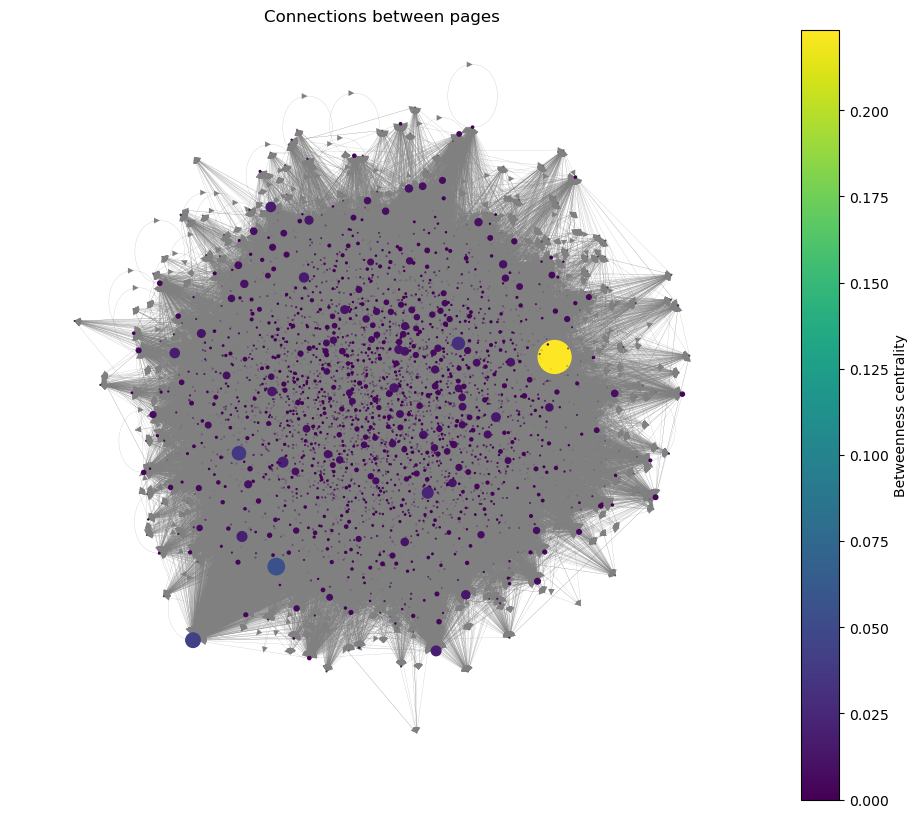

In [13]:
largest_cc = max(nx.strongly_connected_components(DG_sections), key=len)
DG_sub = DG_sections.subgraph(largest_cc).copy()

bet_cent = nx.betweenness_centrality(DG_sub)
bet_cent = {k: v for k, v in sorted(bet_cent.items(), key=lambda item: item[1])}

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import matplotlib as mpl

deg = dict(DG_sub.degree())
node_sizes = [bet_cent[n]*2500 for n in DG_sub.nodes()]
bet_cent_vals = [bet_cent[n] for n in DG_sub.nodes()]

# compute layout once
pos = nx.forceatlas2_layout(DG_sub)

fig, ax = plt.subplots(figsize=(12, 10))

nx.draw(DG_sub, pos, 
        node_size=node_sizes,   
        node_color=bet_cent_vals,   
        cmap=plt.cm.viridis,   
        ax=ax, 
        edge_color='grey',
        width=0.1)

sm = mpl.cm.ScalarMappable(cmap=plt.cm.viridis, 
                           norm=mpl.colors.Normalize(vmin=min(bet_cent_vals), vmax=max(bet_cent_vals)))
sm.set_array(bet_cent_vals)
fig.colorbar(sm, ax=ax, label='Betweenness centrality')

ax.set_title('Connections between pages')
ax.axis('off')
plt.show()

In [69]:
# Save the section-aware graph
import pickle
with open(os.path.join('graphs', 'dg_sections_v2.pickle'), 'wb') as f:
    pickle.dump(DG_sections, f)

print("Saved DG_sections to graphs/dg_sections_v2.pickle")

Saved DG_sections to graphs/dg_sections_v2.pickle


## Network of episodes and directors/writers

In [35]:
# Extract writer and director information from episode pages
import re

def get_episode_creators(file: str, path: str = 'GoT_files') -> dict:
    """Extract writer and director information from an episode page.
    
    Returns:
        Dictionary with 'writers' and 'directors' lists
    """
    with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
        text = f.read()
    
    result = {
        'writers': [],
        'directors': []
    }
    
    # Look for the Episode infobox template
    # Writers are typically in | Writer = or | Writers =
    writer_match = re.search(r'\|\s*Writers?\s*=\s*(.+?)(?=\n\||\n}})', text, re.DOTALL | re.IGNORECASE)
    if writer_match:
        writer_text = writer_match.group(1)
        # Extract [[Name]] links
        writers = re.findall(r'\[\[([^\]|]+?)(?:\|[^\]]+?)?\]\]', writer_text)
        result['writers'] = writers
    
    # Directors are typically in | Director = or | Directors =
    director_match = re.search(r'\|\s*Directors?\s*=\s*(.+?)(?=\n\||\n}})', text, re.DOTALL | re.IGNORECASE)
    if director_match:
        director_text = director_match.group(1)
        # Extract [[Name]] links
        directors = re.findall(r'\[\[([^\]|]+?)(?:\|[^\]]+?)?\]\]', director_text)
        result['directors'] = directors
    
    return result

# Test on one episode
test_creators = get_episode_creators('A Golden Crown.txt')
print("Writers:", test_creators['writers'])
print("Directors:", test_creators['directors'])

Writers: ['Jane Espenson', 'David Benioff', 'D.B. Weiss']
Directors: ['Daniel Minahan']


In [44]:
# Alternative approach: find episodes directly from categories containing "— Episode"
all_normalized_cats = set()
pages_by_pattern = {
    "— Episode": [],
    "— Season": [],
}

for page, text in page_texts.items():
    section_data = get_links_by_section(page + '.txt')
    page_cats = section_data['categories']
    normalized = clean_categories(page_cats, category_map)
    all_normalized_cats.update(normalized)
    
    # Check if this page has episode-like categories
    for cat in normalized:
        if "— Episode" in cat:
            pages_by_pattern["— Episode"].append((page, cat))
        if "— Season" in cat and "Episode" in cat:
            pages_by_pattern["— Season"].append((page, cat))

print(f"Categories containing '— Episode': {len([c for c in all_normalized_cats if '— Episode' in c])}")
print(f"Categories containing '— Season' and 'Episode': {len([c for c in all_normalized_cats if '— Season' in c and 'Episode' in c])}")

print(f"\nSample categories with 'Season':")
season_cats = sorted([c for c in all_normalized_cats if 'Season' in c])[:20]
for cat in season_cats:
    print(f"  {cat}")

print(f"\nPages with '— Episode' in their categories: {len(pages_by_pattern['— Episode'])}")
if pages_by_pattern["— Episode"]:
    print("Sample:")
    for page, cat in pages_by_pattern["— Episode"][:5]:
        print(f"  {page} -> {cat}")


Categories containing '— Episode': 0
Categories containing '— Season' and 'Episode': 0

Sample categories with 'Season':
  A Knight of the Seven Kingdoms: Season 1
  A Knight of the Seven Kingdoms: Season 2
  A Knight of the Seven Kingdoms: Season 3
  Appearances in A Knight of the Seven Kingdoms: Season 1
  Appearances in Game of Thrones: Season 1
  Appearances in Game of Thrones: Season 2
  Appearances in Game of Thrones: Season 3
  Appearances in Game of Thrones: Season 4
  Appearances in Game of Thrones: Season 5
  Appearances in Game of Thrones: Season 6
  Appearances in Game of Thrones: Season 7
  Appearances in Game of Thrones: Season 8
  Appearances in House of the Dragon: Season 1
  Appearances in House of the Dragon: Season 2
  Episodes of A Knight of the Seven Kingdoms: Season 1
  Episodes of A Knight of the Seven Kingdoms: Season 2
  Episodes of A Knight of the Seven Kingdoms: Season 3
  Episodes of Game of Thrones: Season 1
  Episodes of Game of Thrones: Season 2
  Episode

In [57]:
# Get categories for a specific node
node_name = 'Winter Is Coming'  # or any node name

categories = []
for source, target, data in DG_sections.out_edges(node_name, data=True):
    sections = data.get('sections', [])
    if 'categories' in sections:
        categories.append(target)

print(f"Categories for '{node_name}':")
for cat in categories:
    print(f"  - {cat}")

Categories for 'Winter Is Coming':


In [55]:
for node in list(DG_sections.nodes()):
    if 'Winter Is Coming' in node:
        print(node)

White Walker (Winter Is Coming)
Winter Is Coming (disambiguation)
Winter Is Coming (short)
Winter Is Coming
Winter Is Coming_Appearances


In [58]:
list(DG_sections.out_edges('Winter Is Coming'))

[('Winter Is Coming', 'David Benioff'),
 ('Winter Is Coming', 'D.B. Weiss'),
 ('Winter Is Coming', 'Tim Van Patten'),
 ('Winter Is Coming', 'The Kingsroad'),
 ('Winter Is Coming', 'Game of Thrones'),
 ('Winter Is Coming', 'HBO'),
 ('Winter Is Coming', 'Ranger'),
 ('Winter Is Coming', "Night's Watch"),
 ('Winter Is Coming', 'Knighthood'),
 ('Winter Is Coming', 'Waymar Royce'),
 ('Winter Is Coming', 'Will'),
 ('Winter Is Coming', 'Gared'),
 ('Winter Is Coming', 'Wall'),
 ('Winter Is Coming', 'Free Folk'),
 ('Winter Is Coming', 'Haunted Forest'),
 ('Winter Is Coming', 'Beyond the Wall'),
 ('Winter Is Coming', 'Castle Black'),
 ('Winter Is Coming', "Lord Commander of the Night's Watch"),
 ('Winter Is Coming', 'Jeor Mormont'),
 ('Winter Is Coming', 'White Walker (Winter Is Coming)'),
 ('Winter Is Coming', 'Free Cities'),
 ('Winter Is Coming', 'Pentos'),
 ('Winter Is Coming', 'Narrow Sea'),
 ('Winter Is Coming', 'Viserys Targaryen (son of Aerys II)'),
 ('Winter Is Coming', 'Daenerys Targarye

In [83]:
node_name = 'David Benioff'
categories = DG_sections.nodes[node_name]['categories']
print(f"Categories for {node_name}: {categories}")

Categories for David Benioff: ['Co-creators of Game of Thrones', 'Commentators of Game of Thrones: Inside the Episode', 'Directors of Game of Thrones', 'Showrunners of Game of Thrones', 'Game of Thrones — Cast', 'Writers of Game of Thrones']


In [84]:
# Identify episode nodes using their node category attributes
episode_categories = set([
    'Episode',
    'Episodes of Game of Thrones',
    'Episodes of House of the Dragon', 
    'Episodes of A Knight of the Seven Kingdoms',
])

# Also include specific season episode categories
episode_pattern_categories = [
    'Game of Thrones — Season',
    'House of the Dragon — Season',
    'A Knight of the Seven Kingdoms — Season',
    'Episodes released in',
    'Episodes directed by',
    'Episodes written by'
]

# Find all episode nodes based on their category attributes
episode_nodes = set()
for node in DG_sections.nodes():
    node_cats = DG_sections.nodes[node].get('categories', [])
    
    # Check if node has any episode categories
    for cat in node_cats:
        if cat in episode_categories:
            episode_nodes.add(node)
            break
        
        # Check pattern matches
        for pattern in episode_pattern_categories:
            if pattern in cat:
                episode_nodes.add(node)
                break

print(f"Found {len(episode_nodes)} episode nodes based on category attributes")
print("\nSample episode nodes:")
for i, ep in enumerate(sorted(episode_nodes)[:10], 1):
    print(f"{i}. {ep}")

Found 186 episode nodes based on category attributes

Sample episode nodes:
1. A Golden Crown
2. A Knight of the Seven Kingdoms (Game of Thrones)
3. A Knight of the Seven Kingdoms (The Game Revealed)
4. A Knight of the Seven Kingdoms_ Season 1, Episode 1
5. A Knight of the Seven Kingdoms_ Season 1, Episode 2
6. A Knight of the Seven Kingdoms_ Season 1, Episode 3
7. A Knight of the Seven Kingdoms_ Season 1, Episode 4
8. A Knight of the Seven Kingdoms_ Season 1, Episode 5
9. A Knight of the Seven Kingdoms_ Season 1, Episode 6
10. A Look Ahead to Season 2 with Showrunner Ryan Condal


In [87]:
# Build writer/director graph using the infobox extraction method
DG_creators = nx.DiGraph()

# Track writers and directors
writers_set = set()
directors_set = set()

# Extract from episode pages directly
for episode in episode_nodes:
    file = episode + '.txt'
    if not os.path.exists(os.path.join('GoT_files', file)):
        continue
    
    creators = get_episode_creators(file)
    
    if creators['writers'] or creators['directors']:
        DG_creators.add_node(episode, type='episode')
        
        # Add writers
        for writer in creators['writers']:
            writers_set.add(writer)
            DG_creators.add_node(writer, type='writer')
            # Bidirectional edges
            DG_creators.add_edge(writer, episode, relationship='wrote')
            DG_creators.add_edge(episode, writer, relationship='written_by')
        
        # Add directors
        for director in creators['directors']:
            directors_set.add(director)
            DG_creators.add_node(director, type='director')
            # Bidirectional edges
            DG_creators.add_edge(director, episode, relationship='directed')
            DG_creators.add_edge(episode, director, relationship='directed_by')

print(f"Creator graph from infobox data:")
print(f"  Episodes with creator info: {len([n for n in DG_creators.nodes() if DG_creators.nodes[n].get('type') == 'episode'])}")
print(f"  Writers: {len(writers_set)}")
print(f"  Directors: {len(directors_set)}")
print(f"  Total nodes: {DG_creators.number_of_nodes()}")
print(f"  Total edges: {DG_creators.number_of_edges()}")

Creator graph from infobox data:
  Episodes with creator info: 108
  Writers: 24
  Directors: 27
  Total nodes: 153
  Total edges: 506


In [88]:
# Check various episode-related patterns in categories
all_categories = set()
episode_patterns = {
    "— Episode": set(),
    "Episode": set(),
    "Season": set(),
    "Game of Thrones": set()
}

for page, text in page_texts.items():
    section_data = get_links_by_section(page + '.txt')
    page_cats = section_data['categories']
    normalized = clean_categories(page_cats, category_map)
    
    all_categories.update(normalized)
    
    for cat in normalized:
        if "— Episode" in cat:
            episode_patterns["— Episode"].add(cat)
        if "Episode" in cat:
            episode_patterns["Episode"].add(cat)
        if "Season" in cat:
            episode_patterns["Season"].add(cat)
        if "Game of Thrones" in cat:
            episode_patterns["Game of Thrones"].add(cat)

print(f"Total unique categories: {len(all_categories)}")
print(f"\nCategories by pattern:")
for pattern, cats in episode_patterns.items():
    print(f"  '{pattern}': {len(cats)} categories")
    if cats:
        print(f"    Sample: {sorted(cats)[:3]}")

# Check specifically for pages that look like episodes based on their title
episode_like_pages = [p for p in page_texts.keys() if "Season" in p and "Episode" in p]
print(f"\nPages with 'Season' and 'Episode' in title: {len(episode_like_pages)}")
print(f"  Sample: {episode_like_pages[:5]}")


Total unique categories: 1452

Categories by pattern:
  '— Episode': 0 categories
  'Episode': 111 categories
    Sample: ['Commentators of Game of Thrones: Inside the Episode', 'Commentators of House of the Dragon: Inside the Episode', 'Episodes directed by Alan Taylor']
  'Season': 97 categories
    Sample: ['A Knight of the Seven Kingdoms: Season 1', 'A Knight of the Seven Kingdoms: Season 2', 'A Knight of the Seven Kingdoms: Season 3']
  'Game of Thrones': 74 categories
    Sample: ['Aftershows of Game of Thrones', 'Albums of Game of Thrones', 'Appearances in Game of Thrones: Season 1']

Pages with 'Season' and 'Episode' in title: 45
  Sample: ['A Knight of the Seven Kingdoms_ Season 1, Episode 1', 'A Knight of the Seven Kingdoms_ Season 1, Episode 1_Appearances', 'A Knight of the Seven Kingdoms_ Season 1, Episode 2', 'A Knight of the Seven Kingdoms_ Season 1, Episode 3', 'A Knight of the Seven Kingdoms_ Season 1, Episode 4']


In [95]:
# Example: Find all episodes by a specific writer
writer_name = 'Tim Van Patten'
if writer_name in DG_creators.nodes():
    episodes_by_writer = [n for n in DG_creators.successors(writer_name)
                          if DG_creators.nodes[n].get('type') == 'episode']
    print(f"{writer_name} wrote {len(episodes_by_writer)} episodes:")
    for i, ep in enumerate(sorted(episodes_by_writer)[:15], 1):
        print(f"{i}. {ep}")

Tim Van Patten wrote 2 episodes:
1. The Kingsroad
2. Winter Is Coming


In [94]:
node_name = 'Winter Is Coming'
categories = DG_creators.nodes(node_name)
categories

NodeDataView({'The Old Gods and the New': None, 'Vanessa Taylor': None, 'David Nutter': None, 'House of the Dragon_ Season 3, Episode 8': None, 'Andrij Parekh': None, 'Baelor': None, 'David Benioff': None, 'D.B. Weiss': None, 'Alan Taylor': None, 'Blackwater': None, 'George R.R. Martin': None, 'Neil Marshall': None, 'House of the Dragon_ Season 3, Episode 5': None, 'Nina Lopez-Corrado': None, 'Battle of the Bastards (episode)': None, 'Miguel Sapochnik': None, 'Hardhome (episode)': None, 'Driftmark (episode)': None, 'Kevin Lau': None, 'The Dragon and the Wolf': None, 'Jeremy Podeswa': None, 'The Climb': None, 'Alik Sakharov': None, 'Regent (episode)': None, 'Ti Mikkel': None, 'Clare Kilner': None, 'Sons of the Harpy (episode)': None, 'Dave Hill': None, 'Mark Mylod': None, 'Two Swords': None, 'The Laws of Gods and Men': None, 'Bryan Cogman': None, 'The Rains of Castamere (episode)': None, 'Fire and Blood': None, 'The Black Queen': None, 'Ryan Condal': None, 'Greg Yaitanes': None, 'The Ni

In [96]:
# Save the creator graph
import pickle
with open(os.path.join('graphs', 'dg_creators.pickle'), 'wb') as f:
    pickle.dump(DG_creators, f)

print("Saved DG_creators to graphs/dg_creators.pickle")

Saved DG_creators to graphs/dg_creators.pickle


In [97]:
# Example: Find who worked on a specific episode
episode_name = 'Winter Is Coming'
if episode_name in DG_creators.nodes():
    episode_writers = [n for n in DG_creators.predecessors(episode_name) 
                       if DG_creators.nodes[n].get('type') == 'writer']
    episode_directors = [n for n in DG_creators.predecessors(episode_name) 
                         if DG_creators.nodes[n].get('type') == 'director']
    
    print(f"'{episode_name}' creators:")
    print(f"  Writers: {', '.join(episode_writers) if episode_writers else 'None'}")
    print(f"  Directors: {', '.join(episode_directors) if episode_directors else 'None'}")

'Winter Is Coming' creators:
  Writers: David Benioff, D.B. Weiss
  Directors: Tim Van Patten


Visualizing network with 108 episodes, 18 writers, 27 directors


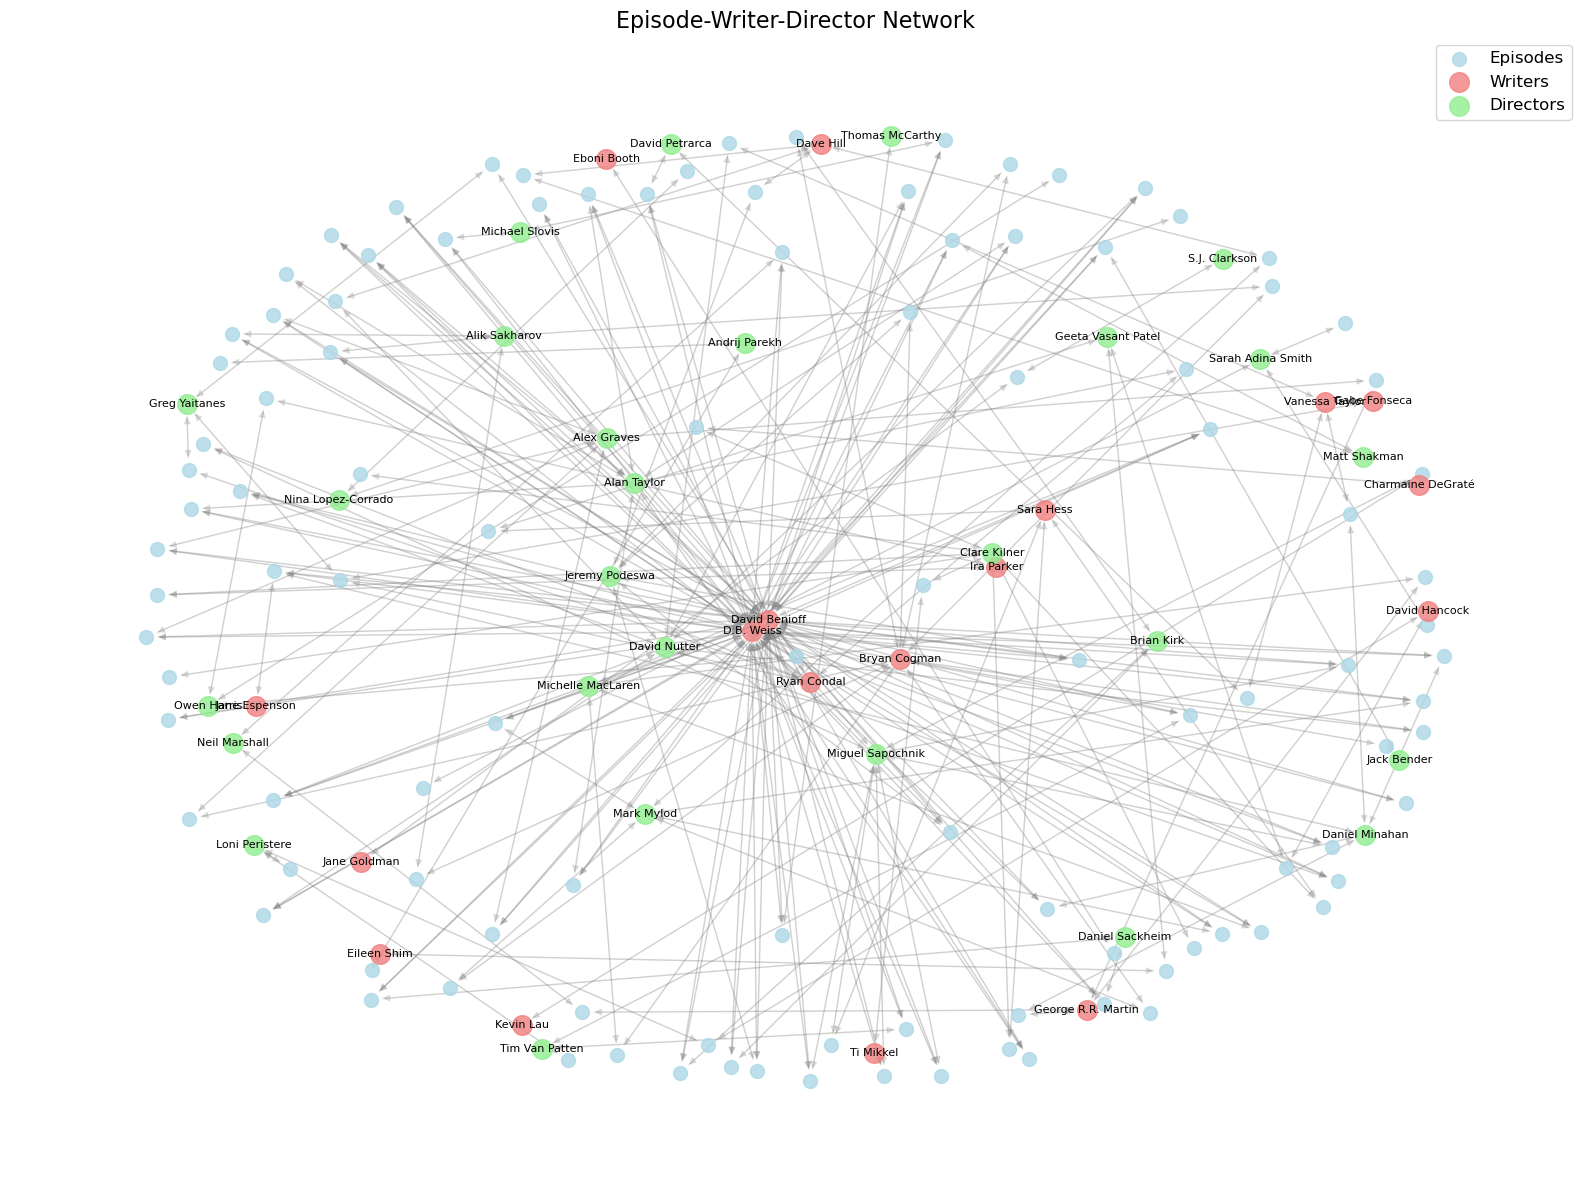

In [99]:
# Visualize the creator network
import matplotlib.pyplot as plt
import networkx as nx

# Get node types for coloring
episodes = [n for n in DG_creators.nodes() if DG_creators.nodes[n].get('type') == 'episode']
writers = [n for n in DG_creators.nodes() if DG_creators.nodes[n].get('type') == 'writer']
directors = [n for n in DG_creators.nodes() if DG_creators.nodes[n].get('type') == 'director']

print(f"Visualizing network with {len(episodes)} episodes, {len(writers)} writers, {len(directors)} directors")

if DG_creators.number_of_nodes() > 0:
    # Create layout
    pos = nx.spring_layout(DG_creators, k=1, iterations=50, seed=42)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Draw edges with reduced opacity
    nx.draw_networkx_edges(DG_creators, pos, alpha=0.2, edge_color='gray', 
                          arrows=True, arrowsize=10, ax=ax)
    
    # Draw nodes by type with different colors
    nx.draw_networkx_nodes(DG_creators, pos, nodelist=episodes, 
                          node_color='lightblue', node_size=100, 
                          label='Episodes', alpha=0.8, ax=ax)
    nx.draw_networkx_nodes(DG_creators, pos, nodelist=writers, 
                          node_color='lightcoral', node_size=200, 
                          label='Writers', alpha=0.8, ax=ax)
    nx.draw_networkx_nodes(DG_creators, pos, nodelist=directors, 
                          node_color='lightgreen', node_size=200, 
                          label='Directors', alpha=0.8, ax=ax)
    
    # Label writers and directors only (too many episodes to label)
    labels = {n: n for n in writers + directors}
    nx.draw_networkx_labels(DG_creators, pos, labels, font_size=8, ax=ax)
    
    ax.set_title('Episode-Writer-Director Network', fontsize=16)
    ax.legend(loc='upper right', fontsize=12)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No data to visualize - graph is empty")

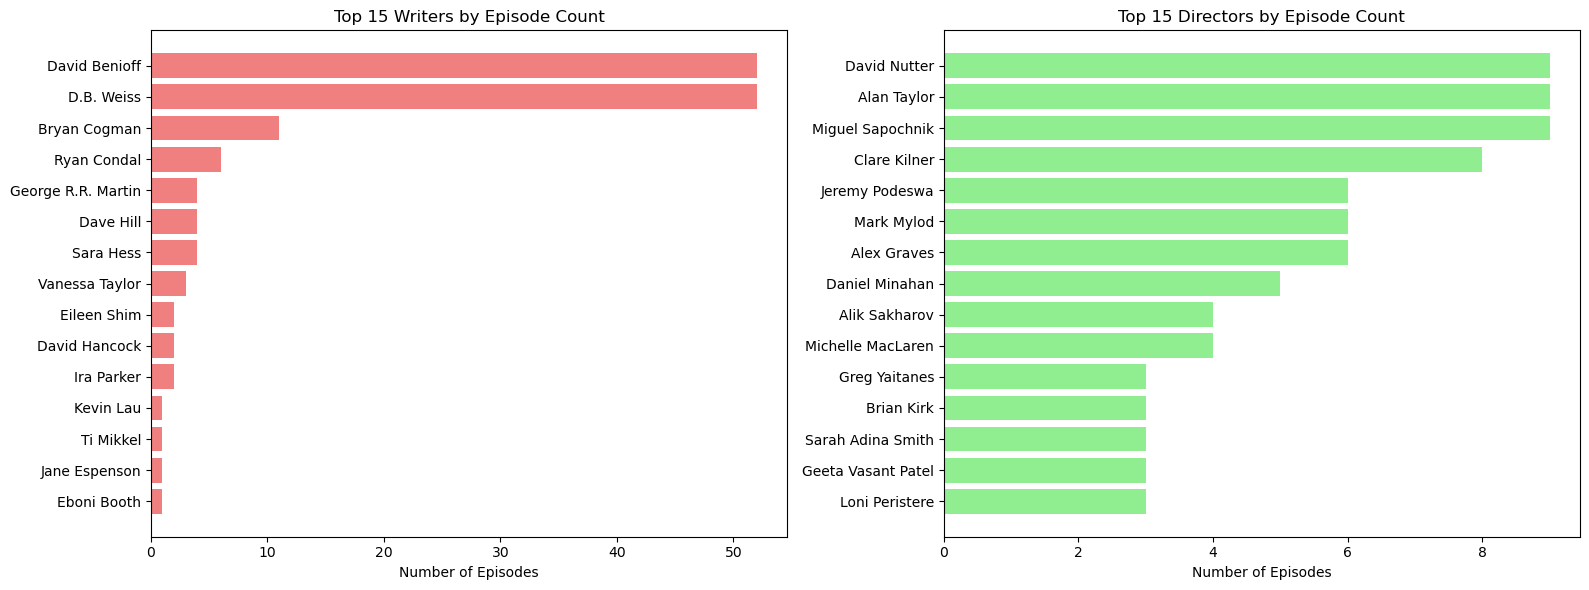


Total unique writers: 18
Total unique directors: 27


In [100]:
# Analyze top writers and directors by episode count
if DG_creators.number_of_nodes() > 0:
    # Count episodes per writer
    writer_episode_counts = {}
    for writer in writers:
        episode_count = len([n for n in DG_creators.successors(writer) 
                           if DG_creators.nodes[n].get('type') == 'episode'])
        if episode_count > 0:
            writer_episode_counts[writer] = episode_count
    
    # Count episodes per director
    director_episode_counts = {}
    for director in directors:
        episode_count = len([n for n in DG_creators.successors(director) 
                           if DG_creators.nodes[n].get('type') == 'episode'])
        if episode_count > 0:
            director_episode_counts[director] = episode_count
    
    # Create bar charts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top writers
    if writer_episode_counts:
        top_writers = sorted(writer_episode_counts.items(), key=lambda x: x[1], reverse=True)[:15]
        names, counts = zip(*top_writers)
        ax1.barh(range(len(names)), counts, color='lightcoral')
        ax1.set_yticks(range(len(names)))
        ax1.set_yticklabels(names)
        ax1.set_xlabel('Number of Episodes')
        ax1.set_title('Top 15 Writers by Episode Count')
        ax1.invert_yaxis()
    
    # Top directors
    if director_episode_counts:
        top_directors = sorted(director_episode_counts.items(), key=lambda x: x[1], reverse=True)[:15]
        names, counts = zip(*top_directors)
        ax2.barh(range(len(names)), counts, color='lightgreen')
        ax2.set_yticks(range(len(names)))
        ax2.set_yticklabels(names)
        ax2.set_xlabel('Number of Episodes')
        ax2.set_title('Top 15 Directors by Episode Count')
        ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal unique writers: {len(writer_episode_counts)}")
    print(f"Total unique directors: {len(director_episode_counts)}")

# Character Network

Extract character connections from the graph

In [98]:
node_name = 'Jon Snow'
categories = DG_sections.nodes[node_name]['categories']
print(f"Categories for {node_name}: {categories}")

Categories for Jon Snow: ['Bannermen of House Stark', "Deserters of the Night's Watch", 'Dragonriders', 'Exiles', 'Free Folk', 'Individuals appearing in Game of Thrones', 'Individuals appearing in Game of Thrones: A Telltale Games Series', 'Individuals narrating Histories & Lore', 'Kings in the North', 'Kinslayers', "Lords Commander of the Night's Watch", 'Members of House Targaryen', 'Northmen', 'Princes', 'Spies', "Stewards of the Night's Watch", 'Undead', 'Wardens of the North']


In [ ]:
# Identify character nodes using category attributes
character_categories = set([
    'Individuals from Game of Thrones',
    'Individuals from House of the Dragon',
    'Individuals from A Knight of the Seven Kingdoms',
    'Individuals appearing in Game of Thrones',
    'Individuals appearing in House of the Dragon',
    'Individuals appearing in A Knight of the Seven Kingdoms',
])

# Find all character nodes based on their category attributes
character_nodes = set()
for node in DG_sections.nodes():
    node_cats = DG_sections.nodes[node].get('categories', [])
    
    # Check if node has any character categories
    if any(cat in character_categories for cat in node_cats):
        character_nodes.add(node)

print(f"Found {len(character_nodes)} character nodes based on category attributes")
print("\nSample character nodes:")
for i, char in enumerate(sorted(character_nodes)[:20], 1):
    print(f"{i}. {char}")


Found 894 character nodes based on category attributes

Sample character nodes:
1. Aberdolf Strongbeard
2. Addam
3. Addam Marbrand
4. Addam of Hull
5. Adrack Humble
6. Adrian Redfort
7. Aegon II Targaryen
8. Aegon Targaryen (son of Rhaenyra)
9. Aemma Arryn
10. Aemon
11. Aemond Targaryen
12. Aerion Targaryen
13. Aeron Bracken
14. Aeron Greyjoy
15. Aerys II Targaryen
16. Aggar
17. Aggo (The North Remembers)
18. Aggo (The Red Woman)
19. Alanna
20. Alfred Broome


In [128]:
# Build character network from DG_sections
# Characters are connected if they both link to the same character page

DG_characters = nx.Graph()  # Undirected graph for character connections

# Add all character nodes
for char in character_nodes:
    DG_characters.add_node(char, type='character')

# Track which character pages each character links to
character_links = {}

for source, target, data in DG_sections.edges(data=True):
    sections = data.get('sections', [])
    
    # Skip category-only edges
    if sections == ['categories']:
        continue
    
    # Only track links FROM character pages TO other character pages
    if source in character_nodes and target in character_nodes:
        if source not in character_links:
            character_links[source] = set()
        character_links[source].add(target)

print(f"Tracked direct links for {len(character_links)} characters")

# Connect characters who link to each other (undirected)
# Since we're creating an undirected graph, we only need to add each edge once
edges_added = set()

for char1 in character_nodes:
    if char1 not in character_links:
        continue
    
    # Add edges to characters this character links to
    for char2 in character_links[char1]:
        # Create a canonical edge representation to avoid duplicates
        edge = tuple(sorted([char1, char2]))
        
        if edge not in edges_added:
            DG_characters.add_edge(char1, char2)
            edges_added.add(edge)

print(f"\nCharacter network:")
print(f"  Nodes: {DG_characters.number_of_nodes()}")
print(f"  Edges: {DG_characters.number_of_edges()}")
print(f"  (Each edge represents a direct link between character pages)")

Tracked direct links for 875 characters

Character network:
  Nodes: 894
  Edges: 8034
  (Each edge represents a direct link between character pages)


In [129]:
# Analyze most connected characters
char_degrees = dict(DG_characters.degree())
top_chars = sorted(char_degrees.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 most connected characters (by degree):")
for i, (char, degree) in enumerate(top_chars, 1):
    print(f"{i}. {char}: {degree}")

Top 20 most connected characters (by degree):
1. Jon Snow: 216
2. Tyrion Lannister: 207
3. Eddard Stark: 189
4. Daenerys Targaryen: 186
5. Sansa Stark: 170
6. Arya Stark: 166
7. Jaime Lannister: 165
8. Robb Stark: 160
9. Cersei Lannister: 150
10. Stannis Baratheon: 144
11. Bran Stark: 140
12. Robert Baratheon: 132
13. Tywin Lannister: 126
14. Joffrey Baratheon: 120
15. Rhaenyra Targaryen: 118
16. Catelyn Stark: 118
17. Theon Greyjoy: 110
18. Sandor Clegane: 107
19. Daemon Targaryen: 106
20. Petyr Baelish: 104


In [130]:
bottom_chars = sorted(char_degrees.items(), key=lambda x: x[1], reverse=True)[-20:]
bottom_chars

[('Master of Revels (The Heirs of the Dragon)', 1),
 ('Tom Dunn', 0),
 ('Leo Tyrell', 0),
 ('Rowan', 0),
 ('Bendleton', 0),
 ('Keohane', 0),
 ('Plummer', 0),
 ('Copper Penny', 0),
 ('Faith Militant 1', 0),
 ('Kathe', 0),
 ('Manfred Dondarrion', 0),
 ('Humfrey Hardyng', 0),
 ('Elaena Targaryen (wife of Aenar)', 0),
 ('Roderick Dustin', 0),
 ('Steely Pate', 0),
 ('Skillan', 0),
 ('Tanselle', 0),
 ('Torrhen Manderly', 0),
 ('Jon Roxton', 0),
 ('Joren Stark', 0)]

In [131]:
# Get largest connected component and calculate centrality measures
if DG_characters.number_of_nodes() > 0:
    largest_cc = max(nx.connected_components(DG_characters), key=len)
    DG_characters_main = DG_characters.subgraph(largest_cc).copy()
    
    print(f"Largest connected component: {DG_characters_main.number_of_nodes()} nodes, {DG_characters_main.number_of_edges()} edges")
    
    # Calculate centrality measures
    print("\nCalculating centrality measures...")
    char_betweenness = nx.betweenness_centrality(DG_characters_main)
    char_closeness = nx.closeness_centrality(DG_characters_main)
    char_eigenvector = nx.eigenvector_centrality(DG_characters_main, max_iter=1000)
    
    print("\nTop 10 characters by betweenness centrality:")
    for i, (char, bc) in enumerate(sorted(char_betweenness.items(), key=lambda x: x[1], reverse=True)[:10], 1):
        print(f"{i}. {char}: {bc:.6f}")

Largest connected component: 858 nodes, 7928 edges

Calculating centrality measures...

Top 10 characters by betweenness centrality:
1. Daenerys Targaryen: 0.163435
2. Eddard Stark: 0.106153
3. Jon Snow: 0.095754
4. Arya Stark: 0.073770
5. Rhaenyra Targaryen: 0.062696
6. Daemon Targaryen: 0.061965
7. Tyrion Lannister: 0.061444
8. Stannis Baratheon: 0.050972
9. Sansa Stark: 0.048890
10. Robb Stark: 0.045136

Top 10 characters by betweenness centrality:
1. Daenerys Targaryen: 0.163435
2. Eddard Stark: 0.106153
3. Jon Snow: 0.095754
4. Arya Stark: 0.073770
5. Rhaenyra Targaryen: 0.062696
6. Daemon Targaryen: 0.061965
7. Tyrion Lannister: 0.061444
8. Stannis Baratheon: 0.050972
9. Sansa Stark: 0.048890
10. Robb Stark: 0.045136


Visualizing character network: 858 nodes, 7928 edges


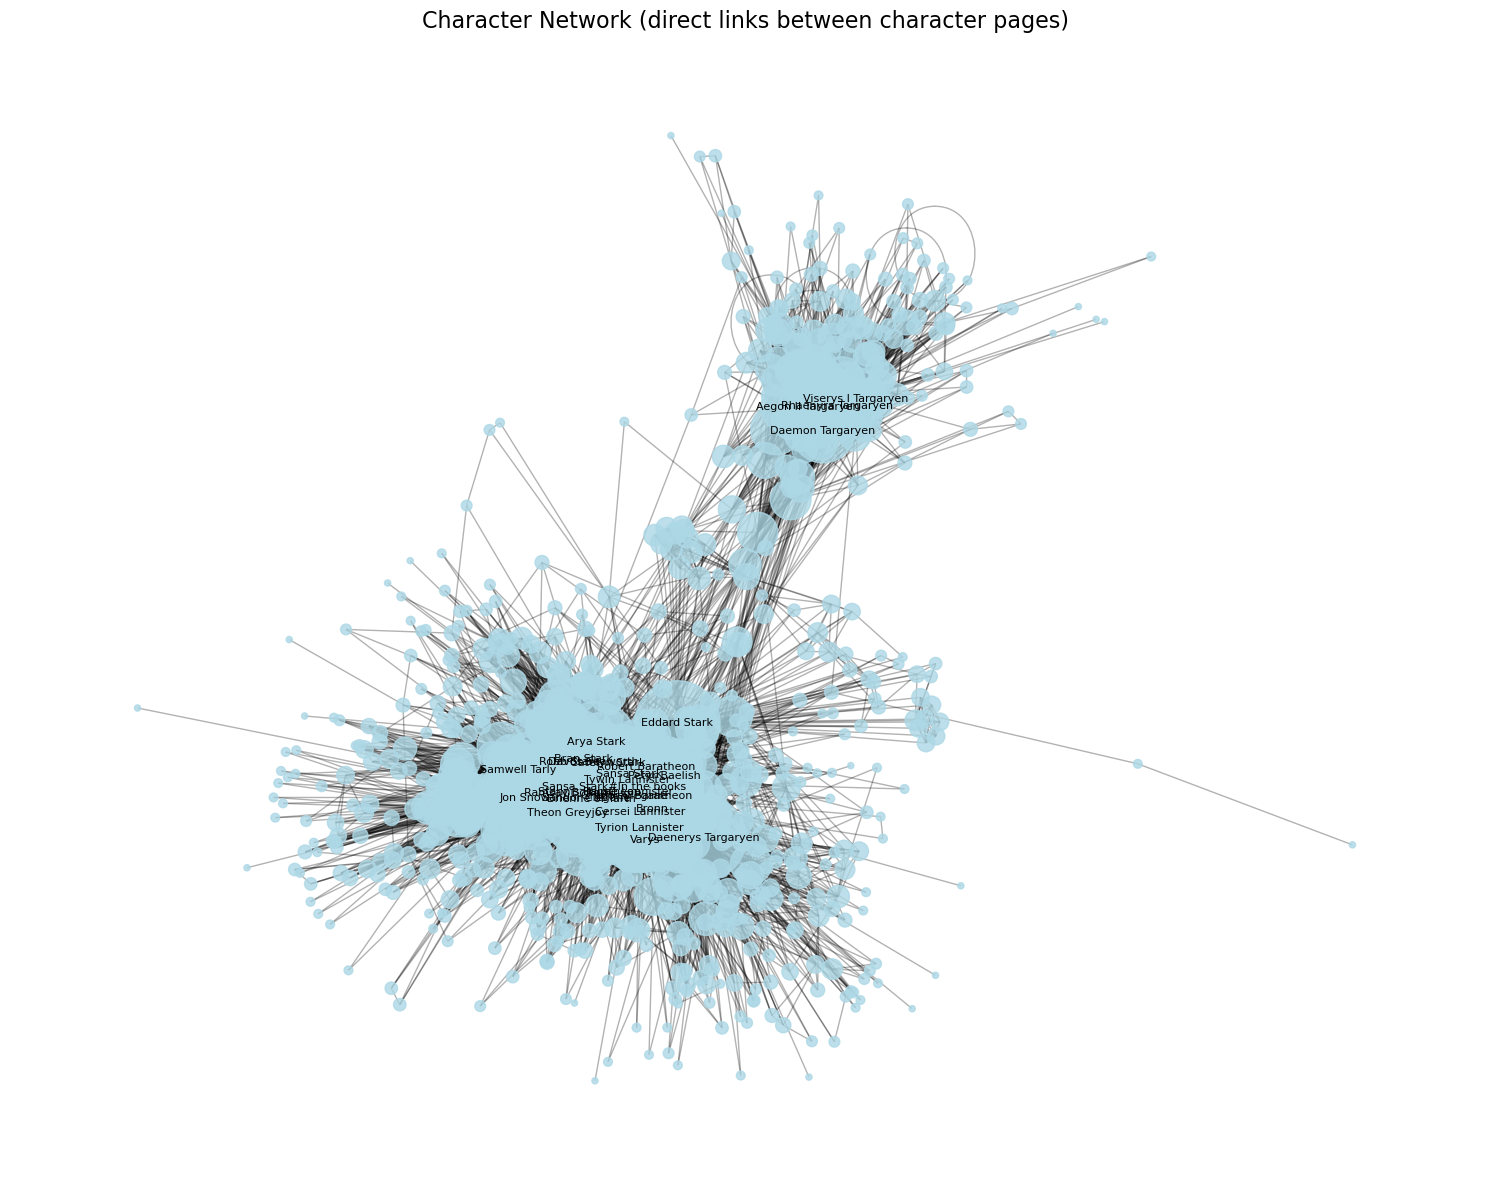

In [132]:
# Visualize the character network
import matplotlib.pyplot as plt

if DG_characters_main.number_of_nodes() > 0:
    print(f"Visualizing character network: {DG_characters_main.number_of_nodes()} nodes, {DG_characters_main.number_of_edges()} edges")
    
    # Calculate layout
    pos = nx.spring_layout(DG_characters_main, k=0.5, iterations=50, seed=42)
    
    # Node sizes by degree
    degrees = dict(DG_characters_main.degree())
    node_sizes = [degrees[n] * 20 for n in DG_characters_main.nodes()]
    
    # Draw
    fig, ax = plt.subplots(figsize=(15, 12))
    
    nx.draw_networkx_edges(DG_characters_main, pos, alpha=0.3, ax=ax)
    nx.draw_networkx_nodes(DG_characters_main, pos, node_size=node_sizes, 
                           node_color='lightblue', alpha=0.8, ax=ax)
    
    # Label top nodes only
    top_n = 30
    top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]
    labels = {node: node for node, _ in top_nodes}
    nx.draw_networkx_labels(DG_characters_main, pos, labels, font_size=8, ax=ax)
    
    ax.set_title(f'Character Network (direct links between character pages)', fontsize=16)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No connected characters to visualize")

In [133]:
# Example: Find connections for a specific character
char_name = 'Jon Snow'
if char_name in DG_characters.nodes():
    neighbors = list(DG_characters.neighbors(char_name))
    print(f"{char_name} is connected to {len(neighbors)} other characters")
    
    print(f"\nDirect character connections:")
    for i, other_char in enumerate(sorted(neighbors)[:15], 1):
        print(f"{i}. {other_char}")

Jon Snow is connected to 216 other characters

Direct character connections:
1. Aberdolf Strongbeard
2. Aemon
3. Aerys II Targaryen
4. Alliser Thorne
5. Allo
6. Alys Karstark
7. Arthur Dayne
8. Arya Stark
9. Balian
10. Barra
11. Bastard's girls
12. Benjen Stark
13. Benjen Stark#In the books
14. Beric Dondarrion
15. Billy


In [134]:
# Save the character network
import pickle
with open(os.path.join('graphs', 'dg_characters.pickle'), 'wb') as f:
    pickle.dump(DG_characters, f)

print("Saved DG_characters to graphs/dg_characters.pickle")

Saved DG_characters to graphs/dg_characters.pickle
